In [1]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 6.7 MB/s eta 0:00:00


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
import sklearn
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from tsfresh.feature_extraction.feature_calculators import absolute_maximum

In [4]:
file_train = 'train.h5'
file_test = 'test.h5'
f_train = h5py.File(file_train, 'r+')
f_test = h5py.File(file_test, 'r+')

In [5]:
def loadData(f1):
  custom_fc_parameters = {
        'absolute_maximum': None,
        'mean': None,
  }

  size = 10000
  increment = 1000
  index = 0
  numpy_matrix = np.zeros(shape = (len(f1['x']), int(size/increment)))
  for j in np.arange(0,size,increment):
      temp_x = []
      for i in range(len(f1['x'])):
          temp_x.append(f1['x'][i][0][j:j+increment])
      df = pd.DataFrame()
      for i, ts in enumerate(temp_x):
          data = [[x, i] for x in ts]
          df_data = pd.DataFrame(data, columns=['x', 'i'])
          df = pd.concat([df, df_data], ignore_index=True)
      df.columns = ['value', 'id']
      tf = extract_features(df, column_id='id', column_value='value', default_fc_parameters=custom_fc_parameters)
      numpy_matrix[:, index] =  tf['value__absolute_maximum'].to_numpy() - tf['value__mean'].to_numpy()
      index += 1
  X = numpy_matrix
  return X



In [6]:
X = loadData(f_train)
temp_y = []
for i in range(len(f_train['y'])):
    temp_y.append(f_train['y'][i])
Y = np.array(temp_y)
col = [f'val{i+1}' for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=col)

Feature Extraction: 100%|██████████| 204/204 [00:00<00:00, 6107.77it/s]


In [7]:
Y_df = pd.Series(Y, name='label')

In [8]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.2, random_state=42)

In [9]:
def Entropy(Y):
  # write your code here
  _, count_labels = np.unique(Y, return_counts=True)
  prob = count_labels/count_labels.sum()
  entropy = -np.sum(prob * np.log2(prob))
  return entropy

def Gini(Y):
  # write your code here
  _, count_labels = np.unique(Y, return_counts=True)
  prob = count_labels / count_labels.sum()
  gini = 1 - np.sum(prob ** 2)
  return gini

In [10]:
class Nodo:
 #Define what your data members will be
  def __init__(self, X, Y, disorder_func, index):
    # Initialize data members
    self.X = X
    self.Y = Y
    self.disorder_func = disorder_func
    self.split_value = -1
    self.Left = None
    self.Right = None
    self.index = index

  def IsTerminal(self):
    # return true if this node has the same labels in Y
    return np.unique(self.Y).size == 1

  def BestSplit(self):
    min_gain = 10
    selected_split_point = -1
    id_split = -1

    _, num_features = self.X.shape
    for id in range(num_features):
      id_name = self.X.columns[id]

      X_sort_id = self.X.sort_values(by=id_name, ascending=True)
      X_id = X_sort_id.iloc[:, id]
      split_points = (X_id + X_id.shift(-1)) / 2
      split_points = split_points.dropna()
      split_points = split_points.round(2)
      for split_point in split_points:
        lower_bound_split = X_id[X_id < split_point]
        higher_bound_split = X_id[X_id >= split_point]
        lobs_size_prob = len(lower_bound_split)/len(X_sort_id)
        hibs_size_prob = len(higher_bound_split)/len(X_sort_id)
        gain = (lobs_size_prob * self.disorder_func(self.Y.loc[lower_bound_split.index]) +
                hibs_size_prob * self.disorder_func(self.Y.loc[higher_bound_split.index]))
        if(gain < min_gain):
          min_gain = gain
          selected_split_point = split_point
          id_split = id
    return min_gain, selected_split_point, id_split


In [11]:
class DT:
  # Defina cuales será sus mimbros datos
  def __init__(self, X, Y, disorder_func=Gini):
    # Inicializar los mimbros datos
    self.node_root = None
    self.X = X
    self.Y = Y
    self.disorder_func = disorder_func

  def create_DT(self, node):
    # write your code here
    if(node.IsTerminal()):
      return
    LNode, RNode = self.Find_Best_Split(node)
    node.Left = LNode
    node.Right = RNode
    self.create_DT(LNode)
    self.create_DT(RNode)

  def Find_Best_Split(self, node):
    # write your code here
    _, selected_split, id = node.BestSplit()
    node.index = id
    node.split_value = selected_split
    id_name = node.X.columns[id]
    upper_data_X = node.X[node.X[id_name] >= selected_split]
    lower_data_X = node.X[node.X[id_name] < selected_split]
    upper_data_Y = node.Y.loc[upper_data_X.index]
    lower_data_Y = node.Y.loc[lower_data_X.index]

    LNode = Nodo(lower_data_X, lower_data_Y, self.disorder_func, 0)
    RNode = Nodo(upper_data_X, upper_data_Y, self.disorder_func, 0)
    return LNode, RNode

  def fit(self):
    self.node_root = Nodo(self.X, self.Y, self.disorder_func, 0)
    self.create_DT(self.node_root)

  def predict(self, X_test):
    predictions = []
    for _, sample in X_test.iterrows():
      node = self.node_root
      while not node.IsTerminal():
        id_name = node.X.columns[node.index]
        if(sample[id_name] < node.split_value):
          node = node.Left
        else:
          node = node.Right
      predictions.append(node.Y.values[0])
    return predictions

In [18]:
dt = DT(X_train, Y_train, Gini)
dt.fit()

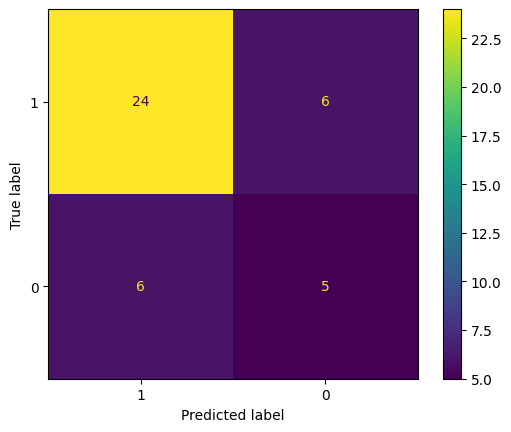

accuracy: 0.7073170731707317


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred = dt.predict(X_test)
labels = Y_test.unique()
conf_matrix = confusion_matrix(Y_test, y_pred)
conf_matrix
accuracy = accuracy_score(Y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = labels)
cm_display.plot()
plt.show()
print(f'accuracy: {accuracy}')

In [20]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, y_pred)
print(f'Decision tree Gini')
print(report)

Decision tree Gini
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        30
           1       0.45      0.45      0.45        11

    accuracy                           0.71        41
   macro avg       0.63      0.63      0.63        41
weighted avg       0.71      0.71      0.71        41



In [21]:
X = loadData(f_test)
col = [f'val{i+1}' for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=col)

Feature Extraction: 100%|██████████| 205/205 [00:00<00:00, 4235.88it/s]


In [22]:
y_pred = dt.predict(X_df)
df_result = pd.DataFrame({
    'id': range(1, len(y_pred) + 1),
    'result': y_pred
})

df_result['result'].value_counts()

result
0    143
1     62
Name: count, dtype: int64

In [23]:
df_result

,id,result
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
200,201,0
201,202,0
202,203,0
203,204,0
